In [1]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import pandas as pd

have a 2d gaussian distribution with 0 mean and I covariance matrix. 
add a 3rd feature whos value is 0 if normal and 5 if outlier.

In [2]:
np.random.seed(42)

# Parameters
num_groups = 50
num_points_per_group = 15
num_features = 3  # Two Gaussian features + one label
num_normal = 40
num_anomalous = 10

# Generate data
dataset = []
for i in range(num_groups):
    label = 0 if i < num_normal else 10  # Normal = 0, Anomalous = 5
    points = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=num_points_per_group)
    feature_3 = np.full((num_points_per_group, 1), label)  # Feature 3 as a column
    group_data = np.hstack([points, feature_3])  # Stack all features to form a 20x3 table
    dataset.append(group_data)

# Convert dataset into a 3D NumPy array
final_dataset = np.array(dataset)  # Shape: (100, 20, 3)

In [3]:
final_dataset

array([[[ 0.49671415, -0.1382643 ,  0.        ],
        [ 0.64768854,  1.52302986,  0.        ],
        [-0.23415337, -0.23413696,  0.        ],
        ...,
        [-0.54438272,  0.11092259,  0.        ],
        [-1.15099358,  0.37569802,  0.        ],
        [-0.60063869, -0.29169375,  0.        ]],

       [[-0.60170661,  1.85227818,  0.        ],
        [-0.01349722, -1.05771093,  0.        ],
        [ 0.82254491, -1.22084365,  0.        ],
        ...,
        [ 1.03099952,  0.93128012,  0.        ],
        [-0.83921752, -0.30921238,  0.        ],
        [ 0.33126343,  0.97554513,  0.        ]],

       [[-0.47917424, -0.18565898,  0.        ],
        [-1.10633497, -1.19620662,  0.        ],
        [ 0.81252582,  1.35624003,  0.        ],
        ...,
        [-0.8084936 , -0.50175704,  0.        ],
        [ 0.91540212,  0.32875111,  0.        ],
        [-0.5297602 ,  0.51326743,  0.        ]],

       ...,

       [[ 1.32819414,  0.55623001, 10.        ],
        [ 0

In [14]:
classifier = OneClassSMMClassifier(datasets=final_dataset, 
                                   nu=0.2, gamma_x=0.1, gamma_d=0.1)
decision, y_pred = classifier.fit()

[10 11 17 23 26 37 40 43 44 46 47]
[0.09201095 0.09999964 0.09973302 0.04952536 0.06543313 0.09999926
 0.09999972 0.09999965 0.09330066 0.09999673 0.09998579]
0.9253901203588105


In [12]:
decision

array([ 2.62829953e-02,  5.98305458e-02,  5.66456368e-02,  4.19997007e-02,
        4.44157959e-02,  6.81300588e-02,  3.33827674e-02, -1.11022302e-16,
        2.34469165e-02,  3.06751100e-02, -2.66443324e-04, -2.66441906e-04,
        6.14267092e-02,  2.53505706e-02,  4.43508564e-02,  4.67703622e-02,
       -2.66442287e-04,  4.07120967e-02, -2.66442266e-04,  4.77697935e-02,
        7.09082379e-02,  4.65254542e-02,  4.22681581e-02,  1.01118890e-02,
        6.75106949e-02,  4.48714880e-02,  2.77137133e-02,  2.72994300e-02,
       -2.66443095e-04,  5.04268314e-02,  2.01173571e-02,  1.92627797e-02,
        6.43187730e-02,  3.43282502e-02,  5.10391042e-02,  7.13920129e-02,
        1.54238229e-02, -2.66444583e-04,  3.66136582e-02,  4.59819965e-02,
       -2.66452734e-04, -2.66435014e-04,  5.32705531e-03, -2.47104473e-04,
       -2.66442270e-04,  4.26146559e-03, -2.66444401e-04, -2.66443397e-04,
       -2.66445163e-04,  2.21901826e-02])

In [6]:
# for i, (score, pred) in enumerate(zip(decision, y_pred)):
#     print(f"Group {i+1}: Decision Score = {score:}, Prediction = {pred}")

TypeError: 'numpy.ndarray' object is not callable

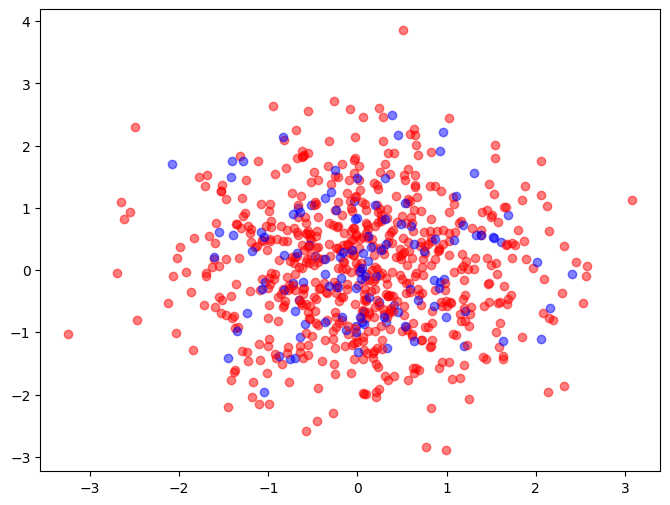

In [10]:
# Create figure
plt.figure(figsize=(8, 6))

# Plot points group-wise
for i in range(final_dataset.shape[0]):  # Iterate over groups
    points = final_dataset[i, :, :2]  # Extract first two features (20x2)
    color = 'red' if decision[i] > 0 else 'blue'  # Use decision function sign
    plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.5)

# Create a mesh grid for decision boundary
x_min, x_max = final_dataset[:, :, 0].min() - 1, final_dataset[:, :, 0].max() + 1
y_min, y_max = final_dataset[:, :, 1].min() - 1, final_dataset[:, :, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Use your decision function to evaluate points
Z = [decision([[x, y]]) for x, y in np.c_[xx.ravel(), yy.ravel()]]
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Anomaly Detection Decision Boundary")
plt.show()